# Local Regularization of 4He System

We've tried a few different nonlocal implementations, maybe we'll have more luck with the local scheme...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import helium4plusplus as he4

plt.style.use('science')

In [2]:
num_states = 3

In [3]:
rgf_lo = np.loadtxt(f'datfiles/he4plusplus_LO_local_n_{num_states}_rg_flow.txt')
Rs = rgf_lo[:, 0]
gs = rgf_lo[:, 1]

In [4]:
ELL = 0
N1 = 6

In [5]:
index = 0
Ri = Rs[index]
gi = gs[index]

sys = he4.LocalHelium4System(Ri, ELL, N1)

In [6]:
sys.a0_and_r0(gi, 0, np.linspace(0.01/he4.BETA6, 0.3/he4.BETA6, 30))

(100.01186809476934, 7.023520444170793)

In [7]:
systems = []
for i in tqdm(range(Rs.size)):
    systems.append(he4.LocalHelium4System(Rs[i], ELL, N1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [02:53<00:00,  5.59s/it]


In [13]:
roots = np.loadtxt('gao/datfiles/roots0.dat', dtype=np.complex128)
ii = np.where(roots[:, 0].real < 10)[0]
Deltas = roots[ii, 0].real
nus = roots[ii, 1]

In [14]:
momenta = np.sqrt(16*Deltas)/he4.BETA6
# momenta = np.linspace(0.1/he4.BETA6, 20/he4.BETA6, 100)

In [16]:
kcds = np.array([
    sys.kcotd_gen_fast(momenta, gi, 0) for (sys, gi) in zip(systems, gs)
])

In [17]:
tands = momenta / kcds
deltas = (np.arctan(tands) + np.pi) % np.pi
xs = 4*np.pi/momenta**2 * np.sin(deltas)**2

In [18]:
import sys
sys.path.append('gao')
import gao_sols as gao

In [21]:
energies = np.array([gao.energy(D, he4.C6) for D in Deltas])
zff = np.array([gao.Zff(en, ELL, nu, he4.C6) for (en, nu) in zip(energies, nus)])
zfg = np.array([gao.Zfg(en, ELL, nu, he4.C6) for (en, nu) in zip(energies, nus)])
zgf = np.array([gao.Zgf(en, ELL, nu, he4.C6) for (en, nu) in zip(energies, nus)])
zgg = np.array([gao.Zgg(en, ELL, nu, he4.C6) for (en, nu) in zip(energies, nus)])

In [24]:
Kell0 = np.array([(zff*td + zfg)/(zgg + zgf*td) for td in tands])

In [36]:
KCD = -1/he4.A0 + he4.R0/2*momenta**2

In [45]:
jj = 120
Deltas[jj]

7.39292929

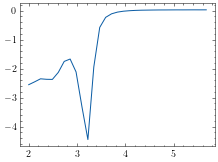

In [46]:
plt.plot(he4.BETA6/Rs, Kell0.real[:, jj])

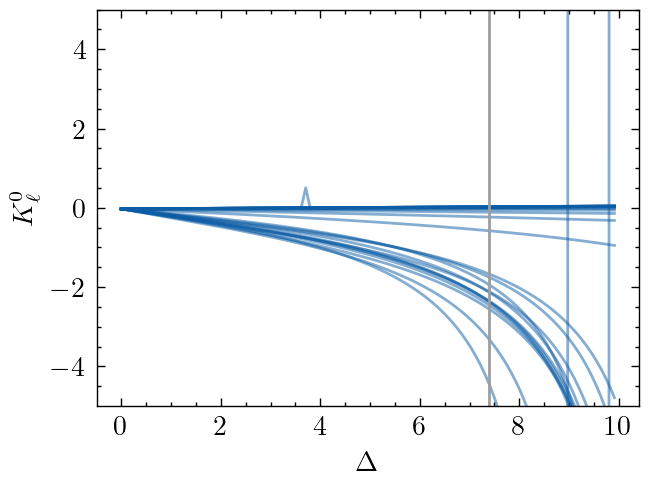

In [47]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for row in Kell0.real:
    ax.plot(Deltas, row, color='C0', alpha=0.5)

ax.axvline(Deltas[jj], color='C6')

ax.set_ylim([-5, 5])
ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$K_\ell^0$');

In [31]:
spectra = np.array([
    sys.bound_state_spectrum(gi, 0) for (sys, gi) in zip(systems, gs)
])

In [32]:
binding_energies = -spectra
momentum_scales = np.sqrt(he4.MASS*binding_energies)

In [33]:
import lm2m2

In [34]:
sys_lm2m2 = lm2m2.LM2M2System(lm2m2.BETA6/5, 0)

In [35]:
kcd_lm2m2 = sys_lm2m2.kcotd_gen_fast(momenta, 0, 0)

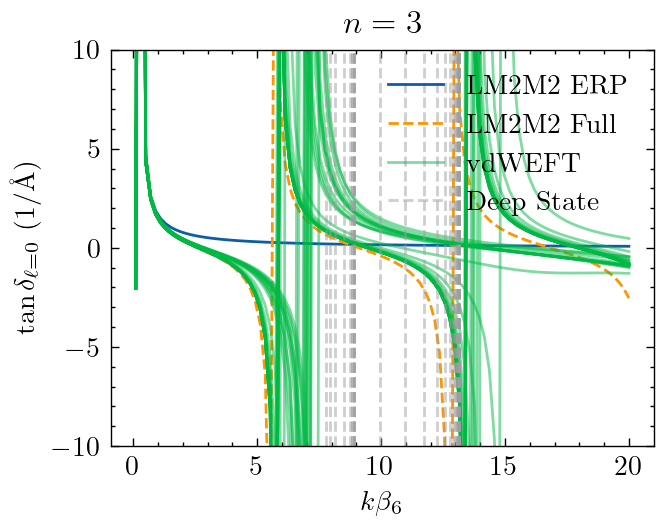

In [56]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(momenta*he4.BETA6, momenta/KCD, label='LM2M2 ERP')
ax.plot(momenta*he4.BETA6, momenta/kcd_lm2m2, label='LM2M2 Full', color='C2', linestyle='--')

label = 'vdWEFT'
for row in tands:
    ax.plot(momenta*he4.BETA6, row, color='C1', alpha=0.5, label=label)
    label = None


label = r'Deep State'
for deep_state_momentum in momentum_scales[:, 1]:
    ax.axvline(deep_state_momentum*he4.BETA6, color='C6', alpha=0.5, linestyle='--', label=label)
    label = None


ax.legend()
ax.set_title(r'$n=%d$' % (num_states))
ax.set_xlabel(r'$k\beta_6$')
ax.set_ylabel(r'$\tan\delta_{\ell=0}$ (1/Å)')

ax.set_ylim([-10, 10]);

Text(0, 0.5, '$\\delta_{\\ell=0}$ (radians)')

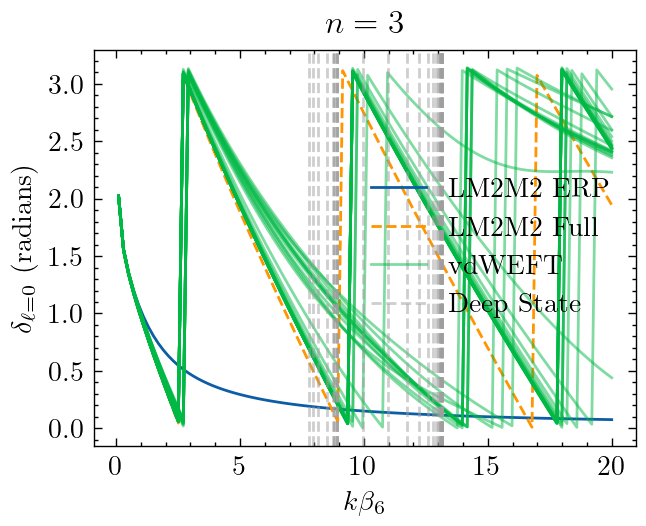

In [57]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(momenta*he4.BETA6, (np.arctan(momenta/KCD)+np.pi) % np.pi, label='LM2M2 ERP')
ax.plot(momenta*he4.BETA6, (np.arctan(momenta/kcd_lm2m2)+np.pi) % np.pi, label='LM2M2 Full', color='C2', linestyle='--')

label = 'vdWEFT'
for row in kcds:
    ax.plot(momenta*he4.BETA6, (np.arctan(momenta/row)+np.pi) % np.pi, color='C1', alpha=0.5, label=label)
    label = None


label = r'Deep State'
for deep_state_momentum in momentum_scales[:, 1]:
    ax.axvline(deep_state_momentum*he4.BETA6, color='C6', alpha=0.5, linestyle='--', label=label)
    label = None


ax.legend()
ax.set_title(r'$n=%d$' % (num_states))
ax.set_xlabel(r'$k\beta_6$')
ax.set_ylabel(r'$\delta_{\ell=0}$ (radians)')

# ax.set_ylim([-10, 10]);

In [74]:
xs_lm2m2 = 4*np.pi/momenta**2*np.sin(np.arctan(momenta/kcd_lm2m2))**2

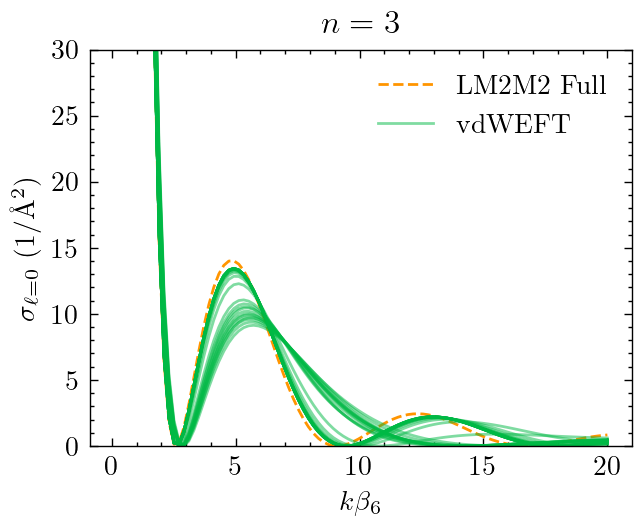

In [75]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

# ax.plot(momenta*he4.BETA6, 4*np.pi/momenta**2*np.sin(np.arctan(momenta/KCD))**2, label='LM2M2 ERP')
ax.plot(momenta*he4.BETA6, xs_lm2m2, label='LM2M2 Full', color='C2', linestyle='--')

label = 'vdWEFT'
for row in xs:
    ax.plot(momenta*he4.BETA6, row, color='C1', alpha=0.5, label=label)
    label = None


ax.legend()
ax.set_title(r'$n=%d$' % (num_states))
ax.set_xlabel(r'$k\beta_6$')
ax.set_ylabel(r'$\sigma_{\ell=0}$ (1/Å${}^2$)');

ax.set_ylim([0, 30]);

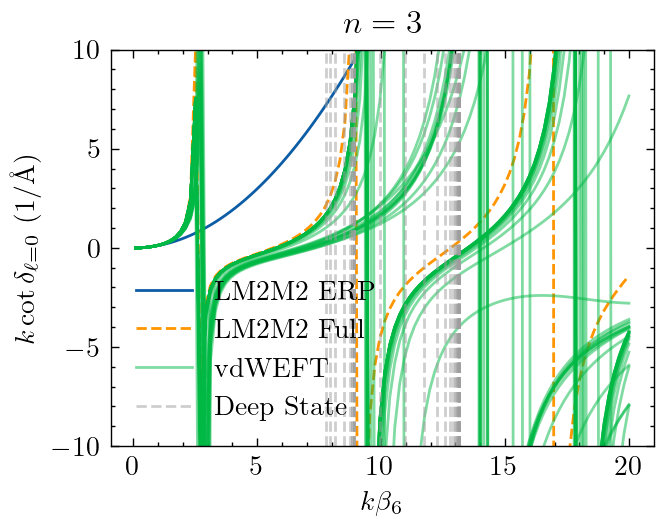

In [68]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(momenta*he4.BETA6, KCD, label='LM2M2 ERP')
ax.plot(momenta*he4.BETA6, kcd_lm2m2, label='LM2M2 Full', color='C2', linestyle='--')

label = 'vdWEFT'
for row in kcds:
    ax.plot(momenta*he4.BETA6, row, color='C1', alpha=0.5, label=label)
    label = None


label = r'Deep State'
for deep_state_momentum in momentum_scales[:, 1]:
    ax.axvline(deep_state_momentum*he4.BETA6, color='C6', alpha=0.5, linestyle='--', label=label)
    label = None


ax.legend()
ax.set_title(r'$n=%d$' % (num_states))
ax.set_xlabel(r'$k\beta_6$')
ax.set_ylabel(r'$k\cot\delta_{\ell=0}$ (1/Å)')

ax.set_ylim([-10, 10]);

In [82]:
kbeta6 = 20
jj = np.argmin(np.abs(momenta*he4.BETA6 - kbeta6))

In [83]:
(momenta/kcd_lm2m2)[jj]

-2.5417857502100794

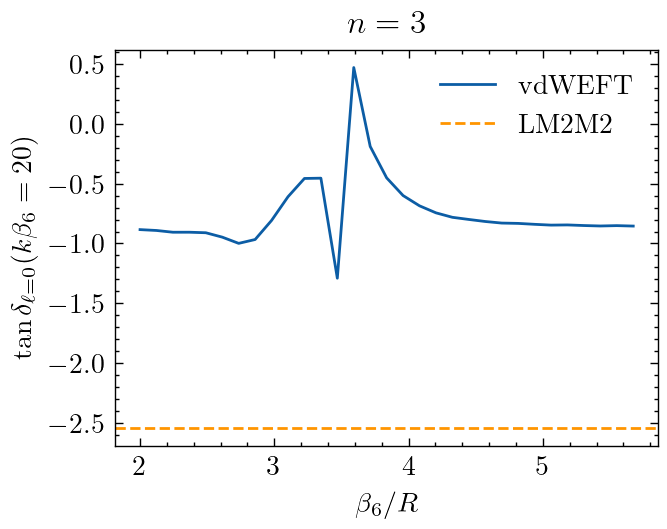

In [84]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, (momenta/kcds)[:, jj], label='vdWEFT')
ax.axhline((momenta/kcd_lm2m2)[jj], color='C2', linestyle='--', label='LM2M2')

ax.legend()
ax.set_title(r'$n=%d$' % (num_states))
ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$\tan\delta_{\ell=0}(k\beta_6=%.0f)$' % (kbeta6));

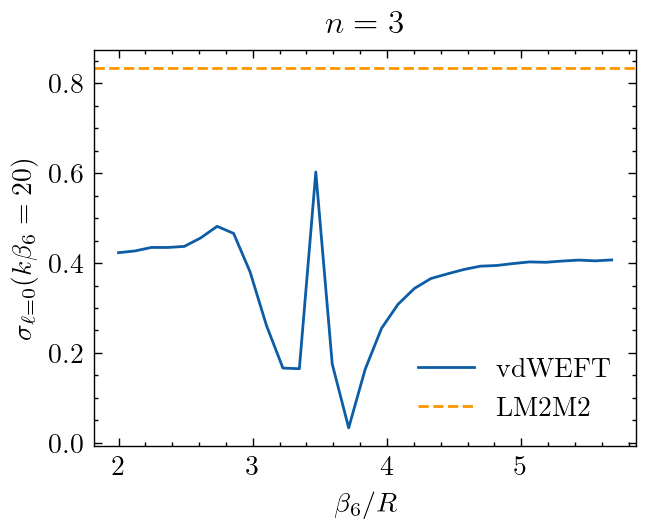

In [85]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, xs[:, jj], label='vdWEFT')
ax.axhline(xs_lm2m2[jj], color='C2', linestyle='--', label='LM2M2')

ax.legend()
ax.set_title(r'$n=%d$' % (num_states))
ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$\sigma_{\ell=0}(k\beta_6=%.0f)$' % (kbeta6));

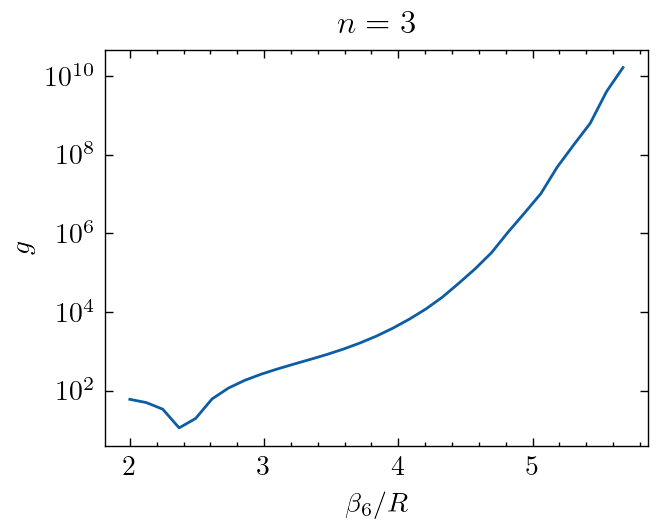

In [72]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, np.abs(gs))

ax.set_title(r'$n=%d$' % (num_states))
ax.set_yscale('log')
ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$g$');